In [1]:
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.applications.densenet import DenseNet121, DenseNet169, DenseNet201 
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, log_loss, jaccard_score
import numpy as np
import os
from PIL import Image
from shutil import copyfile  # Import the copyfile function
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import shutil
import random
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# **Dataset Description**

In [2]:
# Define paths
dataset_path = "/kaggle/input/brain-mri-images-for-brain-tumor-detection" # Total Data path pot_image_sets
train_output_path = "/kaggle/working/Train" # Train data path 
test_output_path = "/kaggle/working/Test" # test data path 


# Create output directories if they don't exist
os.makedirs(train_output_path, exist_ok=True)
os.makedirs(test_output_path, exist_ok=True)


# List all the class directories in the dataset path
class_dirs = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
print(class_dirs)
# Remove 'brain_tumor_dataset' if it exists in the list
if 'brain_tumor_dataset' in class_dirs:
    class_dirs.remove('brain_tumor_dataset')

print("Updated class_dirs:", class_dirs)
# Shuffle the class directories to ensure randomness
random.shuffle(class_dirs)

# Split percentages
train_percentage = 0.7
test_percentage = 0.3



# Loop through each class directory and copy files to appropriate splits
for class_dir in class_dirs:
    files = os.listdir(os.path.join(dataset_path, class_dir))
    random.shuffle(files)
    
    
    total_samples = len(files)
    train_samples = int(train_percentage * total_samples)
    
    test_samples = int(test_percentage * total_samples)
    

    
    
    train_files = files[:train_samples]
    
    test_files = files[train_samples:train_samples + test_samples]
    

    
    
    for filename in train_files:
        src_path = os.path.join(dataset_path, class_dir, filename)
        dest_path = os.path.join(train_output_path, class_dir, filename)
        os.makedirs(os.path.dirname(dest_path), exist_ok=True)
        shutil.copy(src_path, dest_path)
    for filename in test_files:
        src_path = os.path.join(dataset_path, class_dir, filename)
        dest_path = os.path.join(test_output_path, class_dir, filename)
        os.makedirs(os.path.dirname(dest_path), exist_ok=True)
        shutil.copy(src_path, dest_path)




['no', 'yes', 'brain_tumor_dataset']
Updated class_dirs: ['no', 'yes']


In [3]:
import os

base_path = '/kaggle/working/Test'

# Rename 'yes' to 'Tumor'
old_path_yes = os.path.join(base_path, 'yes')
new_path_tumor = os.path.join(base_path, 'Tumor')
os.rename(old_path_yes, new_path_tumor)

# Rename 'no' to 'non-Tumor'
old_path_no = os.path.join(base_path, 'no')
new_path_non_tumor = os.path.join(base_path, 'non-Tumor')
os.rename(old_path_no, new_path_non_tumor)


In [4]:
import os

base_path = '/kaggle/working/Train'

# Rename 'yes' to 'Tumor'
old_path_yes = os.path.join(base_path, 'yes')
new_path_tumor = os.path.join(base_path, 'Tumor')
os.rename(old_path_yes, new_path_tumor)

# Rename 'no' to 'non-Tumor'
old_path_no = os.path.join(base_path, 'no')
new_path_non_tumor = os.path.join(base_path, 'non-Tumor')
os.rename(old_path_no, new_path_non_tumor)


In [5]:
# Define the paths to our train, validation, and test datasets
train_data_dir =  '/kaggle/working/Train'
test_data_dir = '/kaggle/working/Test'
validation_data_dir = '/kaggle/working/Test'

# Image dimensions
IMG_WIDTH, IMG_HEIGHT = 299, 299
input_shape = (IMG_WIDTH, IMG_HEIGHT, 3)  # RGB images


# **Data generators**

In [6]:
# Data generators for RGB images
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)



# Define data generators for RGB images with augmentation
train_datagen_augmented = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,  # Rotation angle range
    width_shift_range=0.2,  # Horizontal shift range
    height_shift_range=0.2,  # Vertical shift range
    shear_range=0.2,  # Shear intensity
    zoom_range=0.2,  # Random zoom range
    horizontal_flip=True,  # Randomly flip images horizontally
    vertical_flip=False,  # Do not flip images vertically
    fill_mode='nearest'  # Fill mode for newly created pixels
)

# Generate augmented data for training
train_generator = train_datagen_augmented.flow_from_directory(
    train_data_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=10,
    class_mode='categorical',
  
)


# Define data generators for RGB images with augmentation
test_datagen_augmented = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,  # Rotation angle range
    width_shift_range=0.2,  # Horizontal shift range
    height_shift_range=0.2,  # Vertical shift range
    shear_range=0.2,  # Shear intensity
    zoom_range=0.2,  # Random zoom range
    horizontal_flip=True,  # Randomly flip images horizontally
    vertical_flip=False,  # Do not flip images vertically
    fill_mode='nearest'  # Fill mode for newly created pixels
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=8,
    class_mode='categorical',
    shuffle=False,
   )

# Define data generators for RGB images with augmentation
validation_datagen_augmented = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,  # Rotation angle range
    width_shift_range=0.2,  # Horizontal shift range
    height_shift_range=0.2,  # Vertical shift range
    shear_range=0.2,  # Shear intensity
    zoom_range=0.2,  # Random zoom range
    horizontal_flip=True,  # Randomly flip images horizontally
    vertical_flip=False,  # Do not flip images vertically
    fill_mode='nearest'  # Fill mode for newly created pixels
)
validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=8,
    class_mode='categorical',
    shuffle=True,
   
)




Found 176 images belonging to 2 classes.
Found 75 images belonging to 2 classes.
Found 75 images belonging to 2 classes.


# ***'Tumor': 0, 'non-Tumor': 1***

In [7]:
class_indices = train_generator.class_indices
print(class_indices)

{'Tumor': 0, 'non-Tumor': 1}


# **Number of images for each class in the training dataset**

In [8]:
# Count the number of images for each class in the training dataset
classes = os.listdir(train_data_dir)
for class_name in classes:
    class_path = os.path.join(train_data_dir, class_name)
    num_images = len(os.listdir(class_path))
    print(f"Class: {class_name}, Number of images: {num_images}")


Class: Tumor, Number of images: 108
Class: non-Tumor, Number of images: 68


# **Check the shape of the images in Train Generator**

In [9]:
# Get a batch of images and labels from the train_generator
batch = train_generator.next()

# Iterate through the batch to check image shapes
for i in range(len(batch[0])):
    img = batch[0][i]  # Image data
    label = batch[1][i]  # Image label
    
    # Get image shape and channels
    height, width, channels = img.shape
    
    # Display image shape and channels
    print(f"Image {i+1} - Shape: {width}x{height}x{channels}, Label: {label}")


Image 1 - Shape: 299x299x3, Label: [1. 0.]
Image 2 - Shape: 299x299x3, Label: [1. 0.]
Image 3 - Shape: 299x299x3, Label: [0. 1.]
Image 4 - Shape: 299x299x3, Label: [0. 1.]
Image 5 - Shape: 299x299x3, Label: [0. 1.]
Image 6 - Shape: 299x299x3, Label: [0. 1.]
Image 7 - Shape: 299x299x3, Label: [1. 0.]
Image 8 - Shape: 299x299x3, Label: [0. 1.]
Image 9 - Shape: 299x299x3, Label: [1. 0.]
Image 10 - Shape: 299x299x3, Label: [1. 0.]


# **Number of images for each class in the testing dataset**

In [10]:
# Count the number of images for each class in the testing dataset
classes = os.listdir(test_data_dir)
for class_name in classes:
    class_path = os.path.join(test_data_dir, class_name)
    num_images = len(os.listdir(class_path))
    print(f"Class: {class_name}, Number of images: {num_images}")


Class: Tumor, Number of images: 46
Class: non-Tumor, Number of images: 29


# **Check the shape of the images in Test Generator**

In [11]:
# Get a batch of images and labels from the test_generator
batch = test_generator.next()

# Iterate through the batch to check image shapes
for i in range(len(batch[0])):
    img = batch[0][i]  # Image data
    label = batch[1][i]  # Image label
    
    # Get image shape and channels
    height, width, channels = img.shape
    
    # Display image shape and channels
    print(f"Image {i+1} - Shape: {width}x{height}x{channels}, Label: {label}")


Image 1 - Shape: 299x299x3, Label: [1. 0.]
Image 2 - Shape: 299x299x3, Label: [1. 0.]
Image 3 - Shape: 299x299x3, Label: [1. 0.]
Image 4 - Shape: 299x299x3, Label: [1. 0.]
Image 5 - Shape: 299x299x3, Label: [1. 0.]
Image 6 - Shape: 299x299x3, Label: [1. 0.]
Image 7 - Shape: 299x299x3, Label: [1. 0.]
Image 8 - Shape: 299x299x3, Label: [1. 0.]


# **Number of images for each class in the validation dataset**

In [12]:
# Count the number of images for each class in the testing dataset
classes = os.listdir(validation_data_dir)
for class_name in classes:
    class_path = os.path.join(validation_data_dir, class_name)
    num_images = len(os.listdir(class_path))
    print(f"Class: {class_name}, Number of images: {num_images}")


Class: Tumor, Number of images: 46
Class: non-Tumor, Number of images: 29


# **Check the shape of the images in Validation Generator**

In [13]:
# Get a batch of images and labels from the validation_generator
batch = validation_generator.next()

# Iterate through the batch to check image shapes
for i in range(len(batch[0])):
    img = batch[0][i]  # Image data
    label = batch[1][i]  # Image label
    
    # Get image shape and channels
    height, width, channels = img.shape
    
    # Display image shape and channels
    print(f"Image {i+1} - Shape: {width}x{height}x{channels}, Label: {label}")


Image 1 - Shape: 299x299x3, Label: [1. 0.]
Image 2 - Shape: 299x299x3, Label: [1. 0.]
Image 3 - Shape: 299x299x3, Label: [1. 0.]
Image 4 - Shape: 299x299x3, Label: [0. 1.]
Image 5 - Shape: 299x299x3, Label: [1. 0.]
Image 6 - Shape: 299x299x3, Label: [0. 1.]
Image 7 - Shape: 299x299x3, Label: [1. 0.]
Image 8 - Shape: 299x299x3, Label: [1. 0.]


# **Check for GPU availability**

In [14]:
# Check for GPU availability
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT available")

# Set TensorFlow to use the GPU device
if tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)
    print("GPU device configured")
else:
    print("No GPU device found")

GPU is available
GPU device configured


# **Model checkpoint**

In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint
model_dir = '/kaggle/working/Checkpoints_InceptionResNetV2'

if not os.path.exists(model_dir):
    os.makedirs(model_dir)

checkpoint_path = model_dir + '/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_best_only=True,  # Save only the best model
                                                 monitor="val_accuracy",   # Monitor validation loss
                                                 mode="max",           # Save the model when validation loss is minimized
                                                 verbose=1)

In [16]:
checkpoint_path

'/kaggle/working/Checkpoints_InceptionResNetV2/cp.ckpt'

# **InceptionResNet for Feature Extractor** 
* ## InceptionResNetV2


In [17]:
from tensorflow.keras import models, layers, optimizers

In [18]:
def create_model(summary=True):
    # apply transfer learning
    new_input = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_tensor=new_input) ##MobileNetV3Small(weights='imagenet', include_top=False, input_tensor=new_input)
    # add new classifier layers
    flat1 = Flatten()(base_model.layers[-1].output)
    output = Dense(2, activation='softmax')(flat1)  
    # define new model
    model = Model(inputs=base_model.inputs, outputs=output)
    # Modify loss function to 'weighted_binary_crossentropy'
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    if summary:
        print(model.summary())
    return model


# **Model summary**

In [19]:
model = create_model()

219055592/219055592 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 149, 149, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)   

# **Training starts here**

In [31]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=15,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=10,
    callbacks=[cp_callback]
    
)

Epoch 1/50
15/15 [==============================] - ETA: 0s - loss: 1.9193 - accuracy: 0.7466
Epoch 1: val_accuracy did not improve from 0.38667
15/15 [==============================] - 4s 279ms/step - loss: 1.9193 - accuracy: 0.7466 - val_loss: 28335.9004 - val_accuracy: 0.3867
Epoch 2/50
15/15 [==============================] - ETA: 0s - loss: 1.8115 - accuracy: 0.7671
Epoch 2: val_accuracy improved from 0.38667 to 0.61333, saving model to /kaggle/working/Checkpoints_InceptionResNetV2/cp.ckpt
15/15 [==============================] - 7s 501ms/step - loss: 1.8115 - accuracy: 0.7671 - val_loss: 223.1181 - val_accuracy: 0.6133
Epoch 3/50
15/15 [==============================] - ETA: 0s - loss: 0.8763 - accuracy: 0.7945
Epoch 3: val_accuracy did not improve from 0.61333
15/15 [==============================] - 4s 275ms/step - loss: 0.8763 - accuracy: 0.7945 - val_loss: 41.9699 - val_accuracy: 0.6000
Epoch 4/50
15/15 [==============================] - ETA: 0s - loss: 0.8991 - accuracy: 0.7

# **Save model history in a CSV file**

# **Accuracy and loss graph of training and validation**
## Here, No. of epochs and (xticks & yticks) will be changed

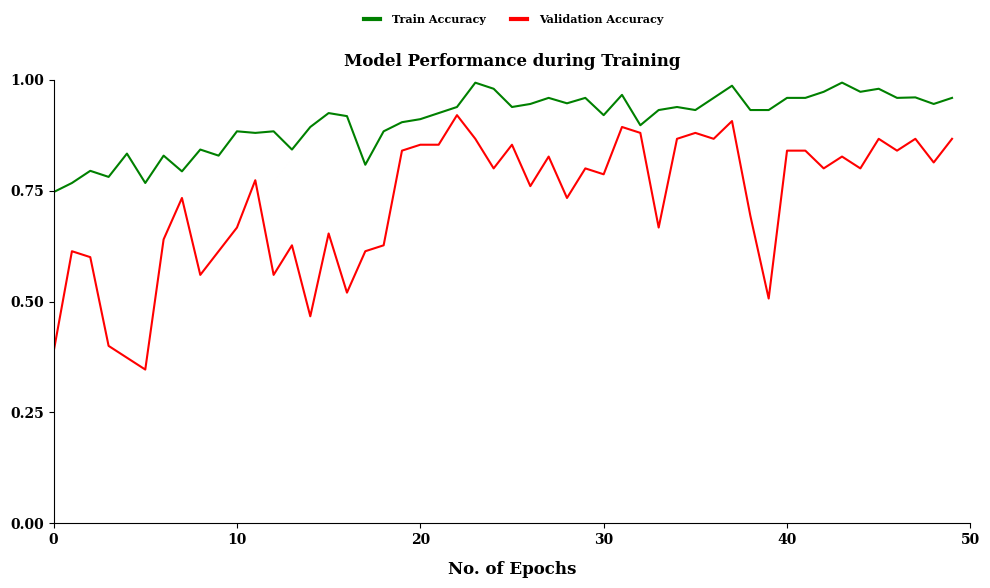

In [32]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerLine2D
import numpy as np

# Plot training & validation loss values
plt.figure(figsize=(10, 6))

# Plot Loss
train_accuracy, = plt.plot(history.history['accuracy'], label='Train Accuracy',  color='green')
val_accuracy, = plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
# Add a title with specified font properties
plt.title('Model Performance during Training', fontdict={'family': 'Serif', 'weight': 'bold', 'size': 12},pad=10)
# Set x-axis label with specified font properties
plt.xlabel('No. of Epochs', fontdict={'family': 'Serif', 'weight': 'bold', 'size': 12})


plt.xticks(np.linspace(0, 150, num=16), fontname='Serif', weight='bold')


# Set y-axis ticks font properties
plt.yticks(np.linspace(0, 1, num=5), fontname='Serif', weight='bold')

# Set the x-axis and y-axis limits
#plt.xlim(0, len(history.history['loss']))

plt.xlim(0, 50)
plt.ylim(0, 1)

# Define custom legend lines with desired line properties
legend_lines = [
    
    Line2D([0], [0], color='green', lw=3),        # Train Accuracy
    Line2D([0], [0], color='red', lw=3)           # Validation Accuracy
]

# Place legend outside the graph by adjusting bbox_to_anchor and specifying it to be outside the axes
plt.legend(legend_lines, [ 'Train Accuracy', 'Validation Accuracy'],
           loc='lower center', bbox_to_anchor=(0.5, 1.1), ncol=5,
           prop={'family': 'Serif', 'weight': 'bold', 'size': 8}, frameon=False,
           handler_map={Line2D: HandlerLine2D(numpoints=5)})

# Adjust padding between x-axis label and x-axis ticks
plt.gca().xaxis.labelpad = 10  # Change the value as needed to adjust the space

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# Adjust layout to prevent cropping
plt.tight_layout()
plt.show()


# **Testing starts here**

## **Load the best checkpoint file**

In [33]:
# Load the latest checkpoint file
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
print(checkpoint_dir)
if latest_checkpoint is not None:
    # Create a new model instance
    loaded_model = create_model(summary=True)

    # Load the previously saved weights and silence the warnings
    status = loaded_model.load_weights(latest_checkpoint)
    status.expect_partial()  # Ignore unrestored variables
else:
    print("No checkpoint file found in the specified directory.")

/kaggle/working/Checkpoints_InceptionResNetV2
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d_406 (Conv2D)         (None, 149, 149, 32)         864       ['input_3[0][0]']             
                                                                                                  
 batch_normalization_406 (B  (None, 149, 149, 32)         96        ['conv2d_406[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_406 (Activation  (None, 149, 149, 

In [34]:
loaded_model.compile(optimizer=Adam(learning_rate=1e-3), loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

# **Evaluate the model on the test set**

In [35]:
test_loss, test_acc = loaded_model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc}")

10/10 [==============================] - 6s 69ms/step - loss: 0.6892 - accuracy: 0.9200
Test Accuracy: 0.9200000166893005


In [36]:
# Predict labels for the test set
predictions = loaded_model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)  
true_classes = test_generator.classes


print("Predicted Classes:", predicted_classes[-10:])  
print("True Classes:", true_classes[-10:])  


10/10 [==============================] - 4s 64ms/step
Predicted Classes: [1 0 1 1 1 1 1 1 1 1]
True Classes: [1 1 1 1 1 1 1 1 1 1]


# **Evaluation Metircs**

In [37]:
print(f"Accuracy: {accuracy_score(true_classes, predicted_classes)}")
print(f"Precision: {precision_score(true_classes, predicted_classes)}")
print(f"Recall: {recall_score(true_classes, predicted_classes)}")
print(f"F1 Score: {f1_score(true_classes, predicted_classes)}")
print(f"Log Loss: {log_loss(true_classes, predicted_classes)}")
print(f"Jaccard Score: {jaccard_score(true_classes, predicted_classes)}")

Accuracy: 0.92
Precision: 0.96
Recall: 0.8275862068965517
F1 Score: 0.888888888888889
Log Loss: 2.8834922711293722
Jaccard Score: 0.8


# **Classification Report**

In [38]:
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes,digits=4))


Classification Report:
              precision    recall  f1-score   support

           0     0.9000    0.9783    0.9375        46
           1     0.9600    0.8276    0.8889        29

    accuracy                         0.9200        75
   macro avg     0.9300    0.9029    0.9132        75
weighted avg     0.9232    0.9200    0.9187        75



# **Confusion Matrix**

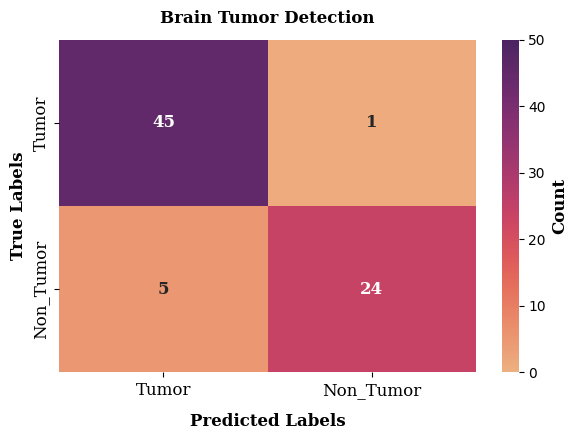

In [39]:
# Generate confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(6, 4.5))
# Define the custom palette
custom_palette = sns.color_palette("flare", as_cmap=True)# Modify the number based on number of classes in the dataset
# Define custom font dictionary for title and labels
font = {'family': 'Serif', 'weight': 'bold', 'size': 12}

# Create heatmap with annotations and colormap
heatmap = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=custom_palette,vmin=0,vmax=50,
                      xticklabels=['Tumor', 'Non_Tumor'], yticklabels=['Tumor', 'Non_Tumor'],annot_kws={"family": "Serif",'weight': 'bold', 'size': 12})

# Set x and y labels with the custom font dictionary
heatmap.set_xlabel('Predicted Labels', fontdict=font)
heatmap.set_ylabel('True Labels', fontdict=font)
heatmap.set_title('Brain Tumor Detection', fontdict=font, pad=12)

# Set font properties for tick labels on both axes
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontname='Serif', fontsize=12)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontname='Serif', fontsize=12)

# Create a color bar to indicate the scale
cbar = heatmap.collections[0].colorbar
cbar.set_label('Count', fontdict=font)
cbar.ax.tick_params(labelsize=10)
# Adjust padding between x-axis label and x-axis ticks
plt.gca().xaxis.labelpad = 10  # Change the value as needed to adjust the space
# Adjust layout to prevent cropping
plt.tight_layout()
plt.savefig('/kaggle/working/InceptionResNetV2_cm.pdf')  # Save as pdf format
plt.show()


# **ROC curve**

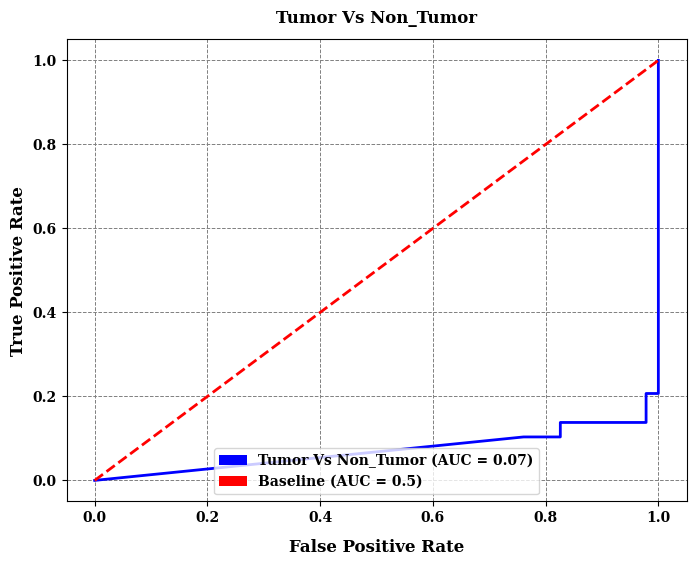

In [40]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from matplotlib.patches import Patch



positive_class_prob = predictions[:, 0]  # Adjust the index based on the column containing the probabilities


# Calculate ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(true_classes, positive_class_prob)
roc_auc = roc_auc_score(true_classes, positive_class_prob)


# Define custom font dictionary for title and labels
font = {'family': 'Serif', 'weight': 'bold', 'size': 12}

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Baseline')
plt.xlabel('False Positive Rate', fontdict=font)
plt.ylabel('True Positive Rate', fontdict=font)
plt.title('Tumor Vs Non_Tumor', fontdict=font, pad=12)

# Create legend entries with bbox
legend_handles = [
    Patch(facecolor='blue',  label='Tumor Vs Non_Tumor (AUC = %0.2f)' % roc_auc),
    Patch(facecolor='red',  label='Baseline (AUC = 0.5)')
]

# Combine loss and accuracy labels with custom legend lines and bbox
plt.legend(handles=legend_handles, loc='lower center', ncol=1, prop={'family': 'Serif', 'weight': 'bold', 'size': 10})

# Enable grid with customized properties
plt.grid(True, linestyle='--', linewidth=0.7, color='gray')

# Set x-axis ticks font properties
plt.xticks(fontname='Serif', weight='bold')

# Set y-axis ticks font properties
plt.yticks(fontname='Serif', weight='bold')

# Adjust padding between x-axis label and x-axis ticks
plt.gca().xaxis.labelpad = 10  # Change the value as needed to adjust the space

plt.show()


# **Checking model predictions for random images from test dataset**

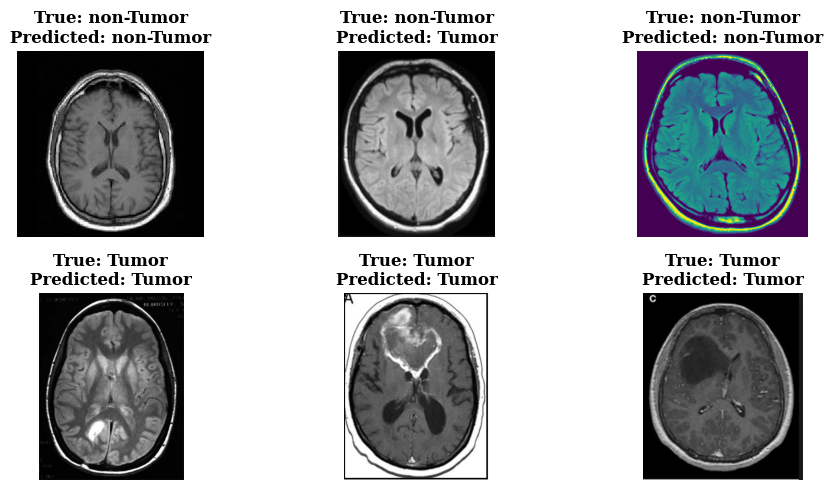

In [46]:
import random
import matplotlib.pyplot as plt
import cv2

# Get random indices for three images
random_indices = random.sample(range(len(true_classes)), 6)

plt.figure(figsize=(10, 5))
for i, idx in enumerate(random_indices, 1):
    # Load the image
    img_path = test_generator.filepaths[idx]
    img = Image.open(img_path)
    
    # Display the image
    plt.subplot(2, 3, i)
    plt.imshow(img)
    plt.axis('off')
    
    # Display the true and predicted labels
    true_label = "Tumor" if true_classes[idx] == 0 else "non-Tumor"
    predicted_label = "Tumor" if predicted_classes[idx] == 0 else "non-Tumor"
    
    plt.title(f"True: {true_label}\nPredicted: {predicted_label}",fontdict={'family': 'Serif', 'weight': 'bold', 'size': 12})

plt.tight_layout()
plt.show()
